# Bayesian Gaussian process latent variable model

In GP-LVM we use a point estimate of the distribution of the latent $\mathbf{X}$. This estimate is derived through maximum likelihood or through a maximum a posteriori (MAP) approach. Ideally, we would like to also estimate a distribution over the latent $\mathbf{X}$. In the Bayesian GPLVM we approximate the true distribution $p(\mathbf{X}|\mathbf{Y})$ by a variational approximation $q(\mathbf{X})$ and integrate $\mathbf{X}$ out. 

Approximating the posterior in this way allows us to optimize a lower bound on the marginal likelihood. Handling the uncertainty in a principled way allows the model to make an assessment of whether a particular latent dimension is required, or the variation is better explained by noise. This allows the algorithm to switch off latent dimensions. 

Let us first setup the GPy library and create some synthetic Gaussian data.

In [89]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import GPy # import GPy package
np.random.seed(12345)
#GPy.plotting.change_plotting_library('plotly')

In [90]:
# Define dataset 
N = 100
k1 = GPy.kern.RBF(5, variance=1, lengthscale=1./np.random.dirichlet(np.r_[10,10,10,0.1,0.1]), ARD=True)
k2 = GPy.kern.RBF(5, variance=1, lengthscale=1./np.random.dirichlet(np.r_[10,0.1,10,0.1,10]), ARD=True)
k3 = GPy.kern.RBF(5, variance=1, lengthscale=1./np.random.dirichlet(np.r_[0.1,0.1,10,10,10]), ARD=True)
X = np.random.normal(0, 1, (N, 5))
A = np.random.multivariate_normal(np.zeros(N), k1.K(X), 10).T
B = np.random.multivariate_normal(np.zeros(N), k2.K(X), 10).T
C = np.random.multivariate_normal(np.zeros(N), k3.K(X), 10).T

Y = np.vstack((A,B,C))
labels = np.hstack((np.zeros(A.shape[0]), np.ones(B.shape[0]), np.ones(C.shape[0])*2))

input_dim = 2 # How many latent dimensions to use
kernel = GPy.kern.RBF(input_dim, 1, ARD=True) 

The synthetic data consists of 300 10-dimensional samples:

In [91]:
Y.shape

(300, 10)

There are no commonly accepted ways to visualize raw 10-dimensional data, but below you can tran and iteratively view different pairs of dimensions of $Y$ to understand how the data is structured.

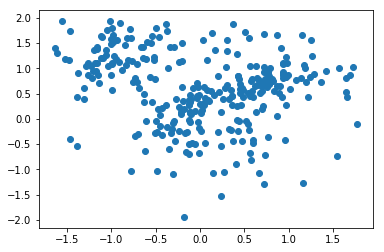

In [92]:
plt.scatter(Y[:, 1], Y[:, 2])

$\textbf{PCA visualization of the data:}$

In [93]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X = pca.fit_transform(Y)
PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
print(pca.explained_variance_ratio_)  
print(pca.singular_values_)  


[0.50841042 0.2584033 ]
[33.32350209 23.75704629]


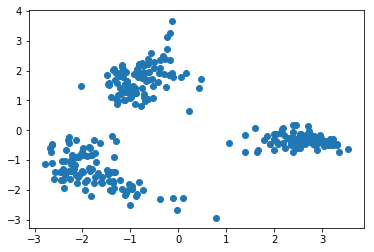

In [94]:
plt.scatter(X[:, 0], X[:, 1])

$\textbf{GPLVM}$: As mentioned above GPLVM finds a point estimate of the distribution of the latent variables $\textbf{X}$. Furthermore, in GPLVM we usually assume that the kernel parameters are known and via optimization discover 'likely' point estimate for $\textbf{X}$. 

In [95]:
Q = input_dim
m_gplvm = GPy.models.GPLVM(Y, Q, kernel=GPy.kern.RBF(Q))
m_gplvm.kern.lengthscale = .2
m_gplvm.kern.variance = 1
m_gplvm.likelihood.variance = 1.
#m2.likelihood.variance.fix(.1)
m_gplvm

GPLVM.,value,constraints,priors
latent_mean,"(300, 2)",,
rbf.variance,1.0,+ve,
rbf.lengthscale,0.2,+ve,
Gaussian_noise.variance,1.0,+ve,


However in a $\textbf{Bayesian GPLVM}$ we take into account the whole distribution over the latent variables $\textbf{X}$ and furthermore we can adopt fully probabilistic Bayesian treatment of the rest of the model parameters. This means that in Bayesian GPLVM, we can only specify the kernel type (although in some cases we can make inference about an appropriate kernel) and leave to the inference to estimate the remaining model parameters. 

In [96]:
m = GPy.models.bayesian_gplvm_minibatch.BayesianGPLVMMiniBatch(Y, input_dim, num_inducing=30, missing_data=True)

$\textbf{Inducing points:}$ The Bayesian GPLVM can be fairly slow to train unless some simplifying assumptions can be made. A common one would be that not all the data is required to estimate accordingly the underlying nonlinear structure and carefully selected small proportion of the data would be sufficient. We will not study in this course how inducing points can be selected, but the interest reader can look at for example (Lawrence, N.D. and Platt, J.C., 2004). 

In [97]:
m.optimize(messages=1, max_iters=5e3)

During optimization note that we have estimated not only the mean of the latent space but also the variance, as well as the kernel parameters. If we want to print the lengthscale parameter of the GP kernel we can just run:

In [98]:
m.kern.lengthscale

index,bayesian_gplvm.rbf.lengthscale,constraints,priors
[0],0.81372492,+ve,
[1],0.88170708,+ve,


One of the key features of the Bayesian GPLVM then is that it allows us to estimate how certain we are for the estimate regions in the latent space and hence indicate which of the latent projections are more trustworthy than others. We can display this on the 3-modal projection of the 10-dimensional data below:

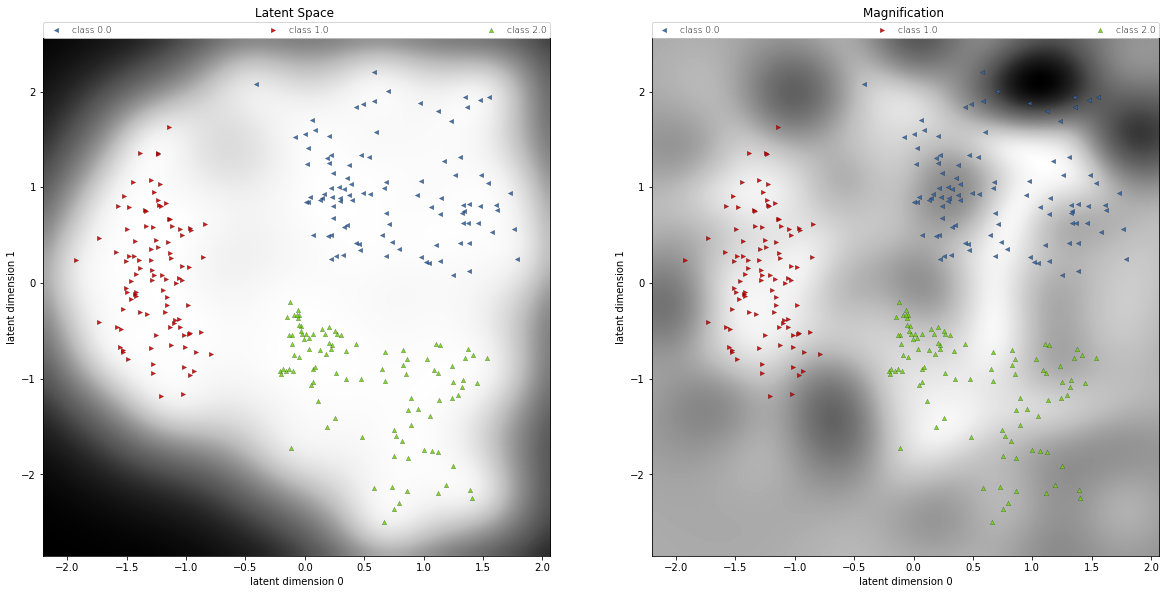

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
axes[0].set_title('Latent Space \n')
v1 = m.plot_latent(labels=labels, ax=axes[0], updates=False)
axes[1].set_title('Magnification \n')
v2 = m.plot_magnification(labels=labels, ax=axes[1], updates=False, resolution=120)

Let us next proceed with an example of the Bayesian GPLVM now used on the digits data we used during the introductory session on GPLVMs.

In [100]:
import matplotlib.pylab as pb
colors = ["#3FCC94", "#DD4F23", "#C6D63B", "#D44271", 
          "#E4A42C", "#4F9139", "#6DDA4C", "#85831F", 
          "#B36A29", "#CF4E4A"]
def plot_model(X, which_dims, labels):
    fig = pb.figure(); ax = fig.add_subplot(111)
    X = X[:,which_dims]
    ulabs = []
    for lab in labels:
        if not lab in ulabs:
            ulabs.append(lab)
            pass
        pass
    for i, lab in enumerate(ulabs):
        ax.scatter(*X[labels==lab].T,marker='o',color=colors[i],label=lab)
        pass
    pass


Data keys:
dict_keys(['Y', 'lbls', 'str_lbls', 'info', 'citation', 'details', 'files', 'license', 'size', 'urls'])

Citation:
T. de Campos, B. R. Babu, and M. Varma. Character recognition in natural images. VISAPP 2009.

Info:
Digits data set from the de Campos characters data
(330, 256)
(330,)


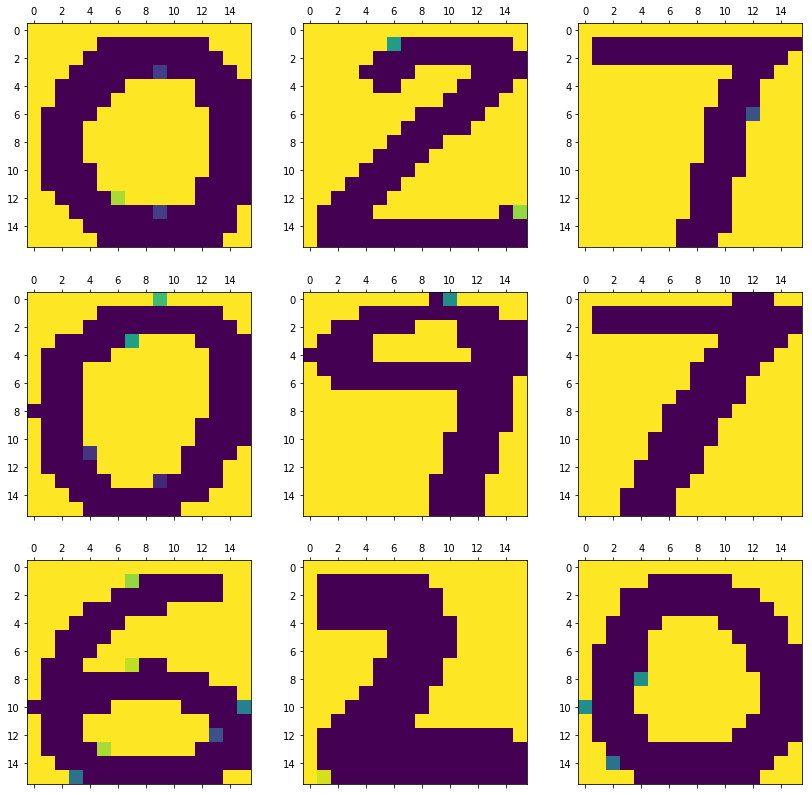

In [101]:
GPy.util.datasets.authorize_download = lambda x: True # This gives GPy permission to download the dataset

# We only select these digits to work with
these_digits = [0, 1, 2, 6, 7, 9]
# Download the data, cache it locally and pass to variable `data`.
data = GPy.util.datasets.decampos_digits(which_digits=these_digits)

print("\nData keys:")
print(data.keys())

print("\nCitation:")
print(data['citation'])

print("\nInfo:")
print(data['info'])
y = data['Y']
labels = data['str_lbls'].flatten()

print(y.shape)
print(labels.shape)
f, axs = plt.subplots(3,3,figsize=(14,14))
for i,k in enumerate(np.random.randint(0, 329, size=(9,1))):
    axs[int(np.floor(i/3)), i%3].matshow(np.reshape(y[k,:],(16,16)))

For scalability let us just select a part of the digits for now and I would encourage you to explore different input digits combinations when studying from this worksheet. 

In [102]:
which = [0,1,2,6,7,9] # which digits to work on
data = GPy.util.datasets.decampos_digits(which_digits=which)
Y = data['Y']
labels = data['str_lbls']
Yn = Y#Y-Y.mean()

In [103]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import GPy
import string

# Model optimization
input_dim = 10 # How many latent dimensions to use
kern = GPy.kern.RBF(input_dim,ARD=True) # ARD kernel
m = GPy.models.BayesianGPLVM(Yn, input_dim=input_dim, kernel=kern, num_inducing=25)

# initialize noise as 1% of variance in data
#m.likelihood.variance = m.Y.var()/100.
m.optimize(messages=1)

In [105]:
m.kern.lengthscale

index,bayesian_gplvm.rbf.lengthscale,constraints,priors
[0],5.10019718,+ve,
[1],2.87037329,+ve,
[2],14.35939737,+ve,
[3],22.87713038,+ve,
[4],14.27258767,+ve,
[5],27.77152979,+ve,
[6],15.17480954,+ve,
[7],28.82029408,+ve,
[8],27.82063539,+ve,
[9],30.70726624,+ve,


Next we can display the estimated projection

[<BarContainer object of 10 artists>]

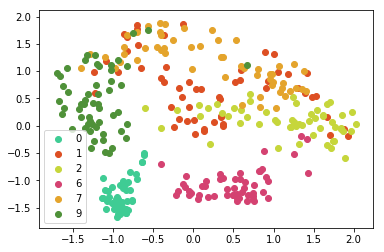

/home/CAMPUS/raykovy/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



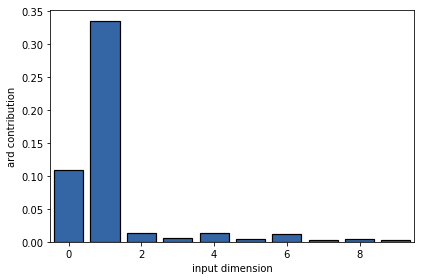

In [83]:
# Plotting the model
plot_model(m.X.mean, m.rbf.lengthscale.argsort()[:2], labels.flatten())
pb.legend()
m.kern.plot_ARD()
# If you are intereste in saving the model:
#m.pickle('digit_bgplvm_rbf.pickle')

$\textbf{Note:}$ The input dimensions of the GPLVM and the Bayesian GPLVM does not need to be fixed to 2. By checking the values of `m.X.mean` you can see that we can use GPLVMs to reduce data to higher number of dimensions as well. However, in this scenario plotting the top 2 most important dimensions makes it fairly easy to understand the underlying structure of the data.

In [84]:
m.X.mean

index,bayesian_gplvm.latent_space.mean,constraints,priors
[0 0],-1.37296417,,
[0 1],-1.07516046,,
[0 2],0.16350868,,
[0 3],-0.43272782,,
[0 4],0.83173731,,
[0 5],0.16529559,,
[0 6],-1.15986423,,
[0 7],-0.13954912,,
[0 8],-0.99065942,,
[0 9],-0.06349552,,


# Manifold Relevance Determination 

In Manifold Relevance Determination we try to find one latent space, common for $K$ observed output sets (modalities) $\{\mathbf{Y}_{k}\}_{k=1}^{K}$. Each modality is associated with a separate set of ARD parameters so that it switches off different parts of the whole latent space and, therefore, $\mathbf{X}$ is softly segmented into parts that are private to some, or shared for all modalities. Can you explain what happens in the following example?

Again, you can stop the optimizer at any point and explore the result obtained with the so far training:

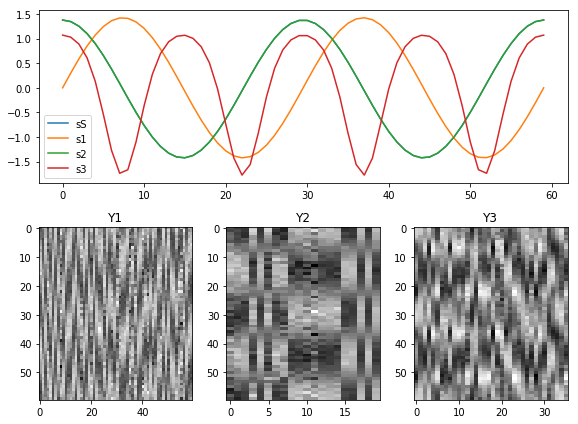

In [85]:
m = GPy.examples.dimensionality_reduction.mrd_simulation(optimize = False, plot=False)
m.optimize(messages = True, max_iters=3e3, optimizer = 'bfgs')

[<BarContainer object of 5 artists>, <BarContainer object of 5 artists>]

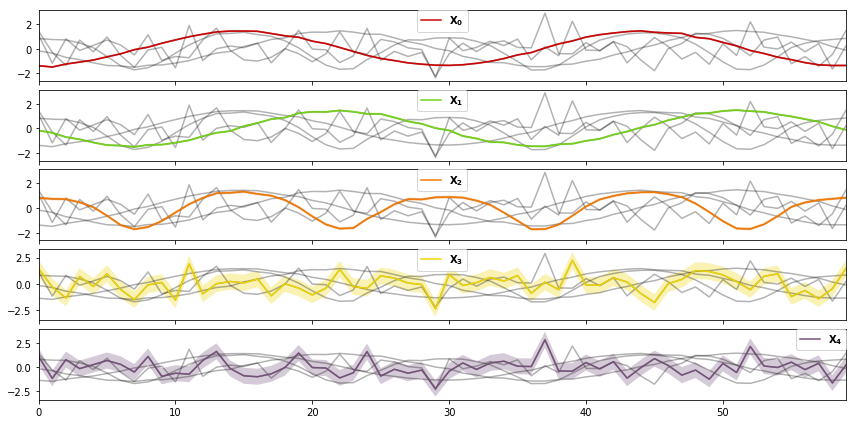

/home/CAMPUS/raykovy/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



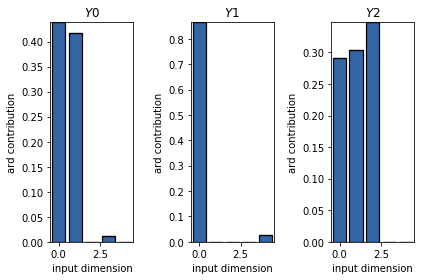

In [86]:
_ = m.X.plot()
m.plot_scales()

$\textbf{Question:}$


The simulated data set is a sinusoid and a double frequency sinusoid function as input signals.

a) Which signal is shared across the three datasets?

b) Which are private?

c) Are there signals shared only between two of the three datasets?